<a href="https://colab.research.google.com/github/jcumbicosr/processamento-linguagem-natural/blob/main/Modelo_de_Linguagem_com_auto_aten%C3%A7%C3%A3o_e_m%C3%A1scara_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercício: Modelo de Linguagem com auto-atenção e máscaras causais

Seguimos na mesma linha de treinar um modelo de linguagem a partir dos textos de Machado de Assis.

Neste exercício, vamos treinar um modelo de linguagem com auto-atenção e com máscara causal. A máscara causal é necessária para que o modelo não tenha acesso a palavras futuras, que é a abordagem usada por grandes modelos de linguagem, como o GPT.

Use a implementação matricial de auto-atenção da aula passada (sobre atenção).

### Modificações necessárias

* Adicione a máscara causal na função `forward` da cabeça de auto-atenção.
* Modificar tokenizador para considerar <sos> (start-of-sequence) e <eos> (end-of-sequence).
* Modifique o nosso dataset para retornar inputs (uma lista de tokens de tamanho $n$), targets (uma lista de tokens de tamanho $n$ deslocada para a esquerda em 1 token). Exemplo `input = [1, 2, 3, 4]`, `target = [2, 3, 4, 5]` para a sequência `[1, 2, 3, 4, 5]` com `seq_len=4`, por exemplo (Ver slide 72).

### Extra
* MultiHeadAttention: modifique a cabeça de auto-atenção para ter múltiplas cabeças. Isso não é obrigatório, mas pode ser interessante para ver como o modelo se comporta.
* Diagrama da geração: fazer diagrama que mostre os passos da geração de tokens (conforme slide 69).
* Verificar o dataloader e ver se está tudo funcionando, especialmente o deslocamento dos tokens à esquerda.

### Dicas

* Use como base o vídeo do Karpathy: https://www.youtube.com/watch?v=kCc8FmEb1nY. Observe que, no vídeo, ele primeiro implementa um modelo bi-grama, depois um modelo de linguagem com auto-atenção. O modelo de auto-atenção é implementado por volta do minuto 40, mas vale a pena assistir o vídeo todo.
* Use esta implementação como base: https://colab.research.google.com/drive/1vFTg4MSXVJwNSzPjaCcvmqhxTP7gK7HA?usp=sharing. Observe como o modelo é organizado e como a máscara é implementada na classe MultiHeadAttention.
* Use `context_size=9`

In [ ]:
!pip install torchinfo -q

In [ ]:
import os
import re
import torch
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.nn import Embedding
from collections import Counter
from torchinfo import summary

## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 2.80 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

min_words = 6 # Minimum number of words per line
cleaned_lines = []
line_lens = []
total_words = 0
# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        # Limpar linhas, removendo \n, espaços antes e depois
        line = line.strip().lower()
        # Remove punctuation marks, except , and.
        line = re.sub(r'[^\w\s,.]', '', line)
        # Apagar linhas menor que min_words
        num_words = len(line.split())
        if num_words < min_words:
            continue
        # Contador de palavras
        total_words += num_words
        cleaned_lines.append(line)
        line_lens.append(len(line))
print(f'Total de linhas: {len(cleaned_lines)}')
print(f'Total de palavras: {total_words}')
print(f'Total de caracteres: {sum(line_lens)}')

Total de linhas: 233809
Total de palavras: 3086352
Total de caracteres: 17226274


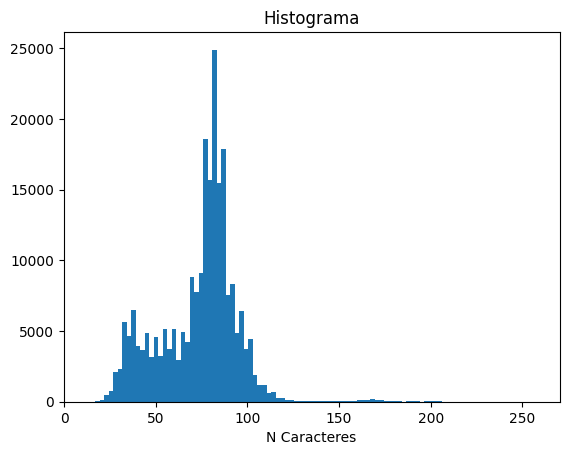

In [ ]:
#@title Plot histogram

plt.title("Histograma")
plt.hist(line_lens, bins=100)
plt.xlabel("N Caracteres")
plt.show()

## Criando um vocabulário

In [ ]:
# Contar número de palavras ÚNICAS
def split_text(text):
    return re.findall(r'\w+|[.,]', text)

def count_words(texts):
    # Counter: collection especifica do Python para contar ocorrências de um objeto
    word_counts = Counter()
    for text in texts:
        # Separar em palavras, incluso caracteres de pontuação
        words = split_text(text)
        word_counts.update(words)
        #### Separado com regex, \w+: sequências alfanuméricas
    return word_counts

word_counts = count_words(cleaned_lines)

len(word_counts)

72140

In [ ]:
VOCAB_SIZE = 5000
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
most_frequent_words = [word for word, count in word_counts.most_common(VOCAB_SIZE)]
vocab = {word: i for i, word in enumerate(most_frequent_words, 4)}
vocab['[PAD]']  = PAD_TOKEN
vocab['[SOS]']  = SOS_TOKEN
vocab['[EOS]']  = EOS_TOKEN
vocab['[UKN]']  = UNK_TOKEN

In [ ]:
# Função de tokenização
def encode_sentence(sentence, vocab):
    return [vocab.get(word, UNK_TOKEN) for word in split_text(sentence)]

random_sentence = random.choice(cleaned_lines)
encoded_sentence = encode_sentence(random_sentence, vocab)
print(f"{random_sentence}\n{encoded_sentence}")

não foi igualmente bonito nem sumário o rolo do largo de são francisco, no dia 8.
[11, 37, 1291, 889, 39, 3, 10, 3, 13, 777, 8, 110, 1587, 4, 27, 63, 3796, 5]


## Classe do dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

context_size = 9 # 5 palavras de entrada. O target é a próxima palavra

"""TODO: Preparar o dataset"""
class MachadoDataset(Dataset):
    def __init__(self, text, vocab, context_size=5, debug=False):
        """
        Dataset class for processing text data for training a language model.
        Args:
            text (list): List of strings representing the text data.
            vocab (Vocabulary): Vocabulary object containing the mapping of tokens to indices.
            context_size (int, optional): Size of the context window. Defaults to 5.
            debug (bool, optional): Whether to print debug information. Defaults to False.
        """
        # Check if text is a list with two or more lines
        if not isinstance(text, list) or len(text) < 2:
            raise ValueError("The 'text' variable must be a list with at least two lines of text.")

        self.vocab = vocab
        self.context_size = context_size
        self.debug = debug

        self.source = []
        self.target = []

        # Loop through each line in the text
        for line in text:
            if self.debug:
                print(f'\n\nRaw text: {line}')
            # Tokenizer the phrase and add special tokens: SOS, EOS
            tokens = [SOS_TOKEN] + encode_sentence(line, vocab) + [EOS_TOKEN]
            if self.debug:
                print(f'Tokens  : {tokens}')

            # Calculate padding if sequence length is not a multiple of context_size
            # padding_length = (context_size - len(tokens) % context_size) % context_size
            # tokens.extend([PAD_TOKEN] * padding_length)

            # Truncate tokens if sequence length is not a multiple of context_size
            max_len = ((len(tokens) -1) // context_size) * context_size
            tokens = tokens[:max_len]
            tokens.extend([EOS_TOKEN])

            if self.debug:
                print(f'Padding : {tokens}')

            # Loop through the sequence with a window of size context_size
            for i in range(len(tokens) - context_size ):
                # Input is a slice of size context_size
                input_seq = tokens[i:i + context_size]
                # Target is a slice of size context_size, shifted right by one position
                target_seq = tokens[i + 1:i + context_size + 1]

                # Replace [UNK] by [PAD] token in target sequence
                target_seq = [0 if token == UNK_TOKEN else token for token in target_seq]

                #if UNK_TOKEN in target_seq:
                #    continue
                #if UNK_TOKEN in input_seq:
                #    continue

                self.source.append(input_seq)
                self.target.append(target_seq)

                if self.debug:
                    # Right-align each number with 5 spaces
                    row1_str = " ".join(f"{num:>5}" for num in input_seq)
                    row2_str = " ".join(f"{num:>5}" for num in target_seq)
                    print(f"source: [{row1_str}]  |  target: [{row2_str}]")

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

In [ ]:
#@title Check Dataset implementation

my_dataset = MachadoDataset(cleaned_lines[6:8], vocab, context_size, debug=True)
sample = my_dataset[0]
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Sample <==')
print(f'Source: {sample[0]}')
print(f'Target: {sample[1]}')



Raw text: estêvão meteu a mão nos cabelos com um gesto de angústia luís alves sacudiu a cabeça
Tokens  : [1, 799, 1710, 6, 134, 72, 693, 17, 12, 239, 8, 4604, 263, 952, 3511, 6, 170, 2]
Padding : [1, 799, 1710, 6, 134, 72, 693, 17, 12, 2]
source: [    1   799  1710     6   134    72   693    17    12]  |  target: [  799  1710     6   134    72   693    17    12     2]


Raw text: e sorriu. achavamse os dois no corredor da casa de luís alves, à rua da constituição,  que
Tokens  : [1, 9, 629, 5, 3, 15, 113, 27, 1055, 14, 44, 8, 263, 952, 4, 28, 128, 14, 3998, 4, 7, 2]
Padding : [1, 9, 629, 5, 3, 15, 113, 27, 1055, 14, 44, 8, 263, 952, 4, 28, 128, 14, 2]
source: [    1     9   629     5     3    15   113    27  1055]  |  target: [    9   629     5     0    15   113    27  1055    14]
source: [    9   629     5     3    15   113    27  1055    14]  |  target: [  629     5     0    15   113    27  1055    14    44]
source: [  629     5     3    15   113    27  1055    14    44]  |  target

In [ ]:
#@title Create the complete dataset

my_dataset = MachadoDataset(cleaned_lines, vocab, context_size)
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Samples <==')
for idx in range(3):
    sample = my_dataset[idx]
    print(f'Source: {sample[0]}  | Target: {sample[1]}')

Length of Dataset: 1123294
==> Samples <==
Source: tensor([  1, 533,   7, 147,   3, 500,   4, 799,   5])  | Target: tensor([533,   7, 147,   0, 500,   4, 799,   5,  11])
Source: tensor([533,   7, 147,   3, 500,   4, 799,   5,  11])  | Target: tensor([  7, 147,   0, 500,   4, 799,   5,  11,  19])
Source: tensor([  7, 147,   3, 500,   4, 799,   5,  11,  19])  | Target: tensor([ 147,    0,  500,    4,  799,    5,   11,   19, 2245])


In [ ]:
#@title Split Dataset

"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""

train_size = int(0.8 * len(my_dataset))
valid_size = len(my_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(my_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(18))

print(f'Train size: {len(train_dataset)}')
print(f'Valid size: {len(valid_dataset)}')

Train size: 898635
Valid size: 224659


In [ ]:
#@title Create DataLoader

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
print(f'Shape of source: {sample[0].shape}')
print(f'Shape of target: {sample[1].shape}')

Shape of source: torch.Size([128, 9])
Shape of target: torch.Size([128, 9])


## Model

In [ ]:
#@title Class definitions
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Multi-Head Attention module.
        Args:
            d_model (int): The dimension of the model.
            num_heads (int): The number of attention heads.
        B = Batch size
        S = Sequence length
        H = Number of heads
        D = Attention head dimension
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.Wv = nn.Linear(d_model, d_model, bias=False)  # the Value part
        self.Wk = nn.Linear(d_model, d_model, bias=False)  # the Key part
        self.Wq = nn.Linear(d_model, d_model, bias=False)  # the Query part
        self.Wo = nn.Linear(d_model, d_model, bias=False)  # the output layer

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.d_k)
        return x.transpose(1, 2)  # (B, H, S, D)

    def scaled_dot_product_attention(self, Q, K, V, attention_mask=None, key_padding_mask=None):
        tgt_len, src_len = Q.size(-2), K.size(-2)
        # (B, H, S, D) * (B, H, D, S) = (B, H, S, S)
        logits = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Attention mask here
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                assert attention_mask.size() == (tgt_len, src_len)
                attention_mask = attention_mask.unsqueeze(0)
                logits = logits + attention_mask
            else:
                raise ValueError(
                    f"Attention mask size {attention_mask.size()}")

        # Key mask here
        # TODO

        attention = torch.softmax(logits, dim=-1)
        # (B, H, S, S) * (B, H, S, D) =  (B, H, S, D)
        output = torch.matmul(attention, V)

        return output, attention

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        # return: (B, S, d_model)
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, attention_mask=None, key_padding_mask=None):
        # Q, K, V: (batch_size, seq_length, d_model)
        V = self.Wv(V)
        K = self.Wk(K)
        Q = self.Wq(Q)

        V = self.split_heads(V)
        K = self.split_heads(K)
        Q = self.split_heads(Q)

        attn_output, attn_weights = self.scaled_dot_product_attention(
            Q, K, V, attention_mask, key_padding_mask)
        grouped = self.combine_heads(attn_output)
        output = self.Wo(grouped)

        return output, attn_weights

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_size, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Point-wise feed forward network
        self.linear1 = nn.Linear(d_model, ff_hidden_size)
        self.linear2 = nn.Linear(ff_hidden_size, d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        self.attention_weights = attn_weights

        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Position-wise feed-forward layer
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


class LanguageModel(torch.nn.Module):
    """TODO: implementar o modelo de linguagem"""
    def __init__(self, vocab_size, embedding_dim, seq_len, hidden_size, num_layers, num_heads, dropout=0.3):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len

        self.embedding = Embedding(vocab_size, embedding_dim)
        #self.positional_encoding = PositionalEncoding(embedding_dim, seq_len)
        self.positional_encoding = Embedding(seq_len, embedding_dim)

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(embedding_dim, num_heads, hidden_size, dropout)
            for _ in range(num_layers)
        ])

        # Specific task
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        #x = self.positional_encoding(x)
        p = self.positional_encoding(torch.arange(x.size(1), device=x.device))
        x = x + p

        for layer in self.decoder_layers:
            x = layer(x, mask)

        # Final MLP model
        x = F.relu(self.fc1(x))  # Use [EOS] token's representation
        x = self.fc2(self.dropout(x))
        return x

In [ ]:
#@title Create model

# Define hyperparameters
vocab_size = len(vocab)+ 1   # Size of the vocabulary
d_model = 64                 # Dimension of model
seq_len = sample[0].size(-1) # Sequence length
hidden_size = 512            # Number of neurons in the hidden layer
num_layers = 2               # Number of layers
num_heads = 4                # Number of heads in multi-head attention

# Model instation
model = LanguageModel(vocab_size, d_model, seq_len, hidden_size, num_layers, num_heads)

summary(model,input_data=sample[0], depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
LanguageModel                            [128, 9, 5005]            --
├─Embedding: 1-1                         [128, 9, 64]              320,320
├─Embedding: 1-2                         [9, 64]                   576
├─ModuleList: 1-3                        --                        --
│    └─DecoderLayer: 2-1                 [128, 9, 64]              --
│    │    └─MultiHeadAttention: 3-1      [128, 9, 64]              16,384
│    │    └─Dropout: 3-2                 [128, 9, 64]              --
│    │    └─LayerNorm: 3-3               [128, 9, 64]              128
│    │    └─Linear: 3-4                  [128, 9, 512]             33,280
│    │    └─Linear: 3-5                  [128, 9, 64]              32,832
│    │    └─Dropout: 3-6                 [128, 9, 64]              --
│    │    └─LayerNorm: 3-7               [128, 9, 64]              128
│    └─DecoderLayer: 2-2                 [128, 9, 64]            

## Training

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#@title Run training
import time

epochs = 5
lr = 1e-4; """TODO, experimente!"""
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN); """TODO CrossEntropy"""

# Model instantiation
model = LanguageModel(vocab_size, d_model, seq_len, hidden_size, num_layers, num_heads)
# Move the model to the appropriate device (GPU or CPU)
model.to(device)


#optimizer = torch.optim.Adam(model.parameters(), lr=lr); """TODO: AdamW ou outro, experimente!"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""TODO: Implemente o loop de treinamento. Em cada época, calcule e imprima a loss no dataset de validação. Opcional: Plote um gráfico da loss de validação e treino"""

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    test_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        # Calculate loss
        loss = criterion(logits.contiguous().view(-1, model.vocab_size),
                             targets.contiguous().view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=-1)
        accuracy = (preds == targets).float().mean()
        test_acc += accuracy.item()

    return total_loss / len(train_loader), (test_acc / len(train_loader)) * 100

def valid_epoch(model, valid_loader, criterion, device):
    ## evaluation
    val_acc = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)

            # Calculate loss
            loss = criterion(logits.contiguous().view(-1, model.vocab_size),
                             targets.contiguous().view(-1))
            val_loss += loss.item()

            # Calculate acc
            preds = logits.argmax(dim=-1)
            accuracy = (preds == targets).float().mean()
            val_acc += accuracy.item()

    return val_loss / len(val_loader), (val_acc / len(val_loader)) * 100

# Save history to dictionnary
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Initial evaluation
val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)
perplexity = torch.exp(torch.tensor(val_loss))
print(f'[Initial] Test loss:{val_loss:.4f}, Test acc:{val_acc:.2f}%, Perplexity:{perplexity:.2f}')

# Training loop
for epoch in range(epochs):
    start_time_epoch = time.time()  # Start time of the epoch

    # train model
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # evaluate model
    val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time_epoch  # Duration of epoch

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(val_loss)
    history['eval_acc'].append(val_acc)

    perplexity = torch.exp(torch.tensor(val_loss))
    print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, Train acc:{train_acc:.2f}%, '
          f'Test loss:{val_loss:.4f}, Test acc: {val_acc:.2f}%, '
          f'Perplexity:{perplexity:.2f}, Elapsed Time: {epoch_duration:.2f} sec')

[Initial] Test loss:8.5351, Test acc:0.01%, Perplexity:5090.27
Epoch [1/5], Train loss:1.5483, Train acc:68.07%, Test loss:0.5338, Test acc: 82.17%, Perplexity:1.71, Elapsed Time: 81.53 sec
Epoch [2/5], Train loss:0.5588, Train acc:81.51%, Test loss:0.5129, Test acc: 82.24%, Perplexity:1.67, Elapsed Time: 82.03 sec
Epoch [3/5], Train loss:0.5267, Train acc:81.92%, Test loss:0.5020, Test acc: 82.28%, Perplexity:1.65, Elapsed Time: 81.70 sec
Epoch [4/5], Train loss:0.5122, Train acc:82.05%, Test loss:0.4948, Test acc: 82.30%, Perplexity:1.64, Elapsed Time: 81.79 sec
Epoch [5/5], Train loss:0.5031, Train acc:82.11%, Test loss:0.4895, Test acc: 82.32%, Perplexity:1.63, Elapsed Time: 82.37 sec


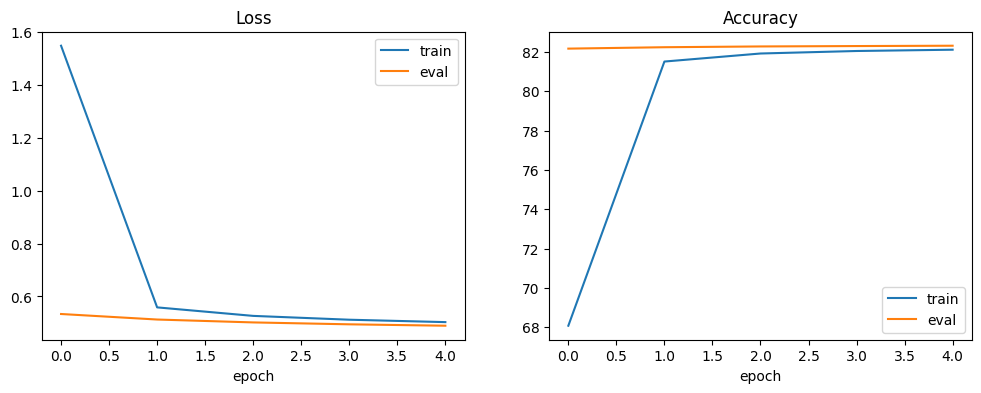

In [ ]:
#@title Plot learning curves

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['eval_loss'], label='eval')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['eval_acc'], label='eval')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

## Exemplo de uso

In [ ]:
"""TODO: implemente a função para gerar texto até atingir o max_length"""

class NextWord(nn.Module):
    def __init__(self, language_model, vocab, context_size):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.vocab = vocab
        self.inverse_vocab = {i: word for word, i in vocab.items()}

    def str_to_tokens(self, sentence):
        return [self.vocab.get(word, UNK_TOKEN) for word in split_text(sentence)]

    def tokens_to_str(self, tokens):
        return ' '.join(self.inverse_vocab[token] for token in tokens)

    def __call__(self, text, max_length, debug=False):
        input = torch.tensor(self.str_to_tokens(text))
        input = torch.cat([torch.tensor([SOS_TOKEN]), input]).to(device)
        input = input.unsqueeze(0)

        self.model.eval()
        with torch.no_grad():
            for step in range(len(input), max_length):
                # if the sequence context is growing too long we must crop it at block_size
                idx_cond = input if input.size(1) <= self.model.seq_len else input[:, -self.model.seq_len:]
                # get the predictions
                logits = self.model(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)

                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                # append sampled index to the running sequence
                input = torch.cat((input, idx_next), dim=1) # (B, T+1)

                if debug:
                    print(f"Context: {idx_cond.tolist()} | Output: {idx_next.tolist()}")

                if idx_next in (EOS_TOKEN, SOS_TOKEN):
                    break
        return self.tokens_to_str(input.squeeze(0).tolist())

next_word = NextWord(model, vocab, context_size)

print(f'\n===========> Test <===========')
text = "bom dia, tudo bem"
max_length= 25
next_word(text, max_length, debug=True)


===========> Test <===========
Context: [[1, 209, 63, 4, 50, 82]] | Output: [[82]]
Context: [[1, 209, 63, 4, 50, 82, 82]] | Output: [[4377]]
Context: [[1, 209, 63, 4, 50, 82, 82, 4377]] | Output: [[2889]]
Context: [[1, 209, 63, 4, 50, 82, 82, 4377, 2889]] | Output: [[4]]
Context: [[209, 63, 4, 50, 82, 82, 4377, 2889, 4]] | Output: [[21]]
Context: [[63, 4, 50, 82, 82, 4377, 2889, 4, 21]] | Output: [[265]]
Context: [[4, 50, 82, 82, 4377, 2889, 4, 21, 265]] | Output: [[8]]
Context: [[50, 82, 82, 4377, 2889, 4, 21, 265, 8]] | Output: [[2]]


'[SOS] bom dia , tudo bem bem oferecer sinceramente , para aquela de [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "que é uma boa literatura"
max_length= 150
next_word(text, max_length)

===========> Test <===========


'[SOS] que é uma boa literatura boa disse boa mais mau [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "mas o que é verdade"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] mas o que é verdade creio é o norte de que fosse era que [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "o chapéu grande precisa de"
max_length= 120
next_word(text, max_length)

===========> Test <===========


'[SOS] o chapéu grande precisa de de mesmo mesmo uma de manhã , a memória [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "excelente dia para ficar em casa,"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] excelente dia para ficar em casa , em qualquer instantes , e causas estava homem . cláudia os bens com a [EOS]'

In [ ]:
print(f'===========> Test <===========')
text = "o mistério nos olhos de capitu"
max_length= 130
next_word(text, max_length)

===========> Test <===========


'[SOS] o mistério nos olhos de capitu o mesmo que soube não ria [EOS]'